### Import needed packages

In [1]:
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily

### Data Preparation

In [2]:
# Path to CSV's
path = '../data/raw'
# Get list of all CSV's in folder
all_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
# Read each CSV and store it in a list of dataframes
df_list = [pd.read_csv(file) for file in all_files]
# Concatenate
combined_df = pd.concat(df_list, ignore_index=True)
# Save combined dataframe as new CSV
combined_df.to_csv('all_bike_data.csv', index=False)

### Specify Time Period and Location for Weather Data

In [3]:
# Set time period for analysis
start = datetime(2024, 8, 1)
end = datetime(2025, 8, 31)

# Create location point for NYC
nyc_location = Point(40.7128, -74.0060, 10)

# Get historical data
data = Daily(nyc_location, start, end)
weather_df = data.fetch()

# Data check
print(weather_df.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2024-08-01  28.7  25.0  33.9   0.0   0.0  <NA>   6.1  <NA>  1013.9  <NA>
2024-08-02  28.1  24.5  32.3   2.4   0.0  <NA>   8.1  <NA>  1011.8  <NA>
2024-08-03  26.7  23.3  32.8   7.1   0.0  <NA>  10.3  <NA>  1010.6  <NA>
2024-08-04  24.2  22.8  27.8   8.7   0.0  <NA>   9.8  <NA>  1013.3  <NA>
2024-08-05  27.3  23.3  33.3   0.0   0.0  <NA>   9.0  <NA>  1015.9  <NA>


### Check merged ride data

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137673 entries, 0 to 1137672
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1137673 non-null  object 
 1   rideable_type       1137673 non-null  object 
 2   started_at          1137673 non-null  object 
 3   ended_at            1137673 non-null  object 
 4   start_station_name  1137669 non-null  object 
 5   start_station_id    1137669 non-null  object 
 6   end_station_name    1134663 non-null  object 
 7   end_station_id      1134112 non-null  object 
 8   start_lat           1137672 non-null  float64
 9   start_lng           1137672 non-null  float64
 10  end_lat             1136290 non-null  float64
 11  end_lng             1136290 non-null  float64
 12  member_casual       1137673 non-null  object 
dtypes: float64(4), object(9)
memory usage: 112.8+ MB


### Check for missing data

In [5]:
combined_df.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       4
start_station_id         4
end_station_name      3010
end_station_id        3561
start_lat                1
start_lng                1
end_lat               1383
end_lng               1383
member_casual            0
dtype: int64

In [6]:
combined_df.describe()

,start_lat,start_lng,end_lat,end_lng
count,1.137672e+06,1.137672e+06,1.136290e+06,1.136290e+06
mean,4.073242e+01,-7.404019e+01,4.073237e+01,-7.403992e+01
std,1.220740e-02,1.205703e-02,1.227776e-02,1.216199e-02
min,4.070658e+01,-7.408670e+01,4.062000e+01,-7.415000e+01
25%,4.072153e+01,-7.404557e+01,4.072112e+01,-7.404425e+01
50%,4.073521e+01,-7.403768e+01,4.073521e+01,-7.403768e+01
75%,4.074266e+01,-7.403097e+01,4.074226e+01,-7.403097e+01
max,4.075453e+01,-7.402402e+01,4.086256e+01,-7.385570e+01


### Convert to datetime

In [7]:
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])

### Creating a ride_duration column

In [8]:
# Subtracting the two colums creates a Timedelta object
combined_df['ride_duration'] = combined_df['ended_at'] - combined_df['started_at']

# Convert to minutes
combined_df['ride_duration_minutes'] = combined_df['ride_duration'].dt.total_seconds() / 60

### Remove nulls

In [9]:
combined_df.dropna(inplace=True)

### Extract hour of day and day of week columns

In [10]:
combined_df['start_hour'] = combined_df['started_at'].dt.hour
combined_df['day_of_week'] = combined_df['started_at'].dt.dayofweek

### Ensure started_at is a datetime object & Resample by day D and get number of rides per day

In [11]:
combined_df.set_index('started_at' , inplace=True)

daily_rides = combined_df['ride_id'].resample('D').count()

print(daily_rides.head())

started_at
2024-07-31       6
2024-08-01    3897
2024-08-02    3335
2024-08-03    3024
2024-08-04    2573
Freq: D, Name: ride_id, dtype: int64


### Merge ride data with weather data

In [12]:
# Convert daily_rides to dataframe
daily_rides_df = daily_rides.reset_index()

# Rename for clarity
daily_rides_df.columns = ['date', 'ride_count']

In [13]:
print(weather_df.head())


            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2024-08-01  28.7  25.0  33.9   0.0   0.0  <NA>   6.1  <NA>  1013.9  <NA>
2024-08-02  28.1  24.5  32.3   2.4   0.0  <NA>   8.1  <NA>  1011.8  <NA>
2024-08-03  26.7  23.3  32.8   7.1   0.0  <NA>  10.3  <NA>  1010.6  <NA>
2024-08-04  24.2  22.8  27.8   8.7   0.0  <NA>   9.8  <NA>  1013.3  <NA>
2024-08-05  27.3  23.3  33.3   0.0   0.0  <NA>   9.0  <NA>  1015.9  <NA>


In [14]:
# Turn 'time' index into regular column
weather_df.reset_index(inplace=True)

In [15]:
# Rename time column to date so both dataframes have matching column
weather_df.rename(columns={'time': 'date'}, inplace=True)

In [16]:
# Merge the dataframes on the date column
merged_df = pd.merge(daily_rides_df, weather_df, on='date', how='inner')

In [17]:
# Display first few rows to  confirm
print(merged_df.head())

        date  ride_count  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0 2024-08-01        3897  28.7  25.0  33.9   0.0   0.0  <NA>   6.1  <NA>   
1 2024-08-02        3335  28.1  24.5  32.3   2.4   0.0  <NA>   8.1  <NA>   
2 2024-08-03        3024  26.7  23.3  32.8   7.1   0.0  <NA>  10.3  <NA>   
3 2024-08-04        2573  24.2  22.8  27.8   8.7   0.0  <NA>   9.8  <NA>   
4 2024-08-05        3620  27.3  23.3  33.3   0.0   0.0  <NA>   9.0  <NA>   

     pres  tsun  
0  1013.9  <NA>  
1  1011.8  <NA>  
2  1010.6  <NA>  
3  1013.3  <NA>  
4  1015.9  <NA>  


# Visualizations

### Busiest Hour of the Day

<Axes: title={'center': 'Bike Rentals by Hour of Day'}, xlabel='Hour of day', ylabel='Total Number of Rides'>

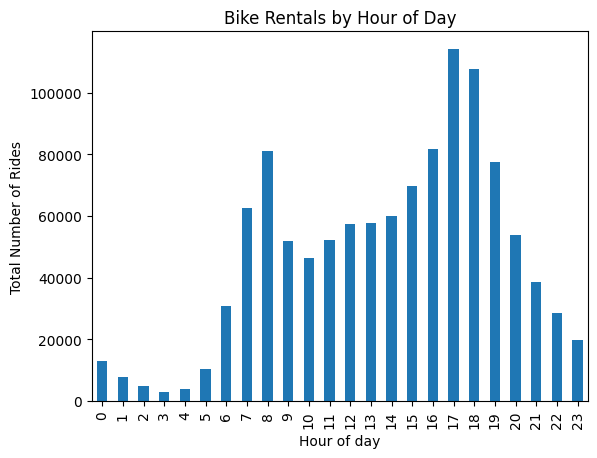

In [18]:
# Busiest hour of day
hourly_counts = combined_df.groupby('start_hour')['ride_id'].count()

# Plot Results
hourly_counts.plot(kind='bar',
                   title='Bike Rentals by Hour of Day',
                   xlabel='Hour of day',
                   ylabel='Total Number of Rides')


### Busiest Days of the Week

<Axes: title={'center': 'Bike Rentals by Day of Week'}, xlabel='Day of Week', ylabel='Total Number of Rides'>

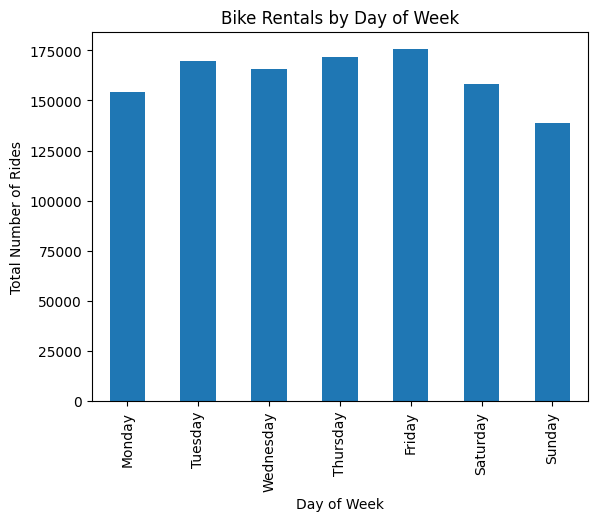

In [19]:
# Same thing but day of week
weekly_counts = combined_df.groupby('day_of_week')['ride_id'].count()

# Map numbers to days
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts.index = weekly_counts.index.map(lambda x: day_names[x])

# Plot results
weekly_counts.plot(kind='bar',
                   title='Bike Rentals by Day of Week',
                   xlabel='Day of Week',
                   ylabel='Total Number of Rides')

### Number of rides vs. Average Temperature

<Axes: title={'center': 'Daily Bike Rides vs Average Temperature'}, xlabel='Average Temperature (C)', ylabel='Total Daily Rides'>

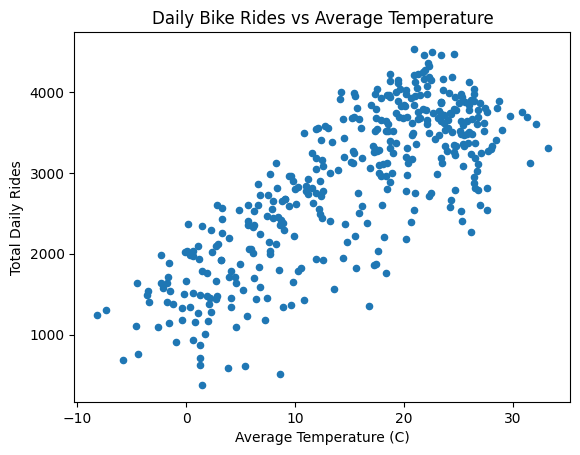

In [20]:
merged_df.plot(kind='scatter',
               x='tavg',
               y='ride_count',
               title='Daily Bike Rides vs Average Temperature',
               xlabel='Average Temperature (C)',
               ylabel='Total Daily Rides')


### Correlation Heatmap showing relationship between temperature, wind, and precipitation to ride frequency

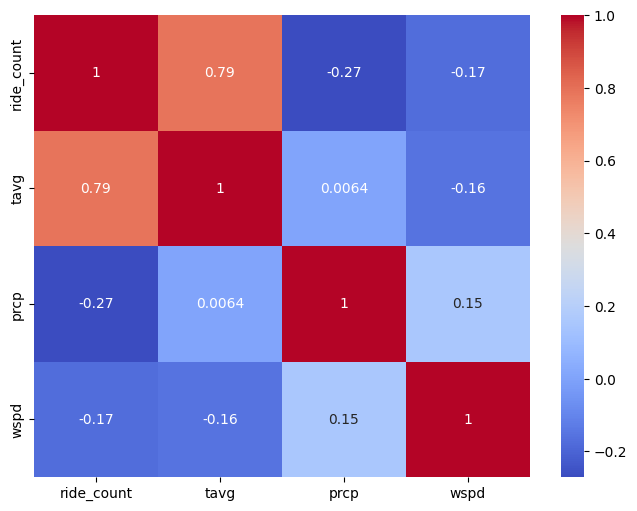

In [21]:
# Correlation Heatmap
numeric_df=merged_df[['ride_count', 'tavg', 'prcp', 'wspd']]

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

### Filtering out extreme outliers, rides shorter than 2-minutes or longer than 180-minutes

In [22]:
# New DataFrame filtering out extreme ride length outliers
plot_df = combined_df[(combined_df['ride_duration_minutes'] > 2) & (combined_df['ride_duration_minutes'] < 180)]


### Violin Plot showing differences in ride lengths between members and casual riders

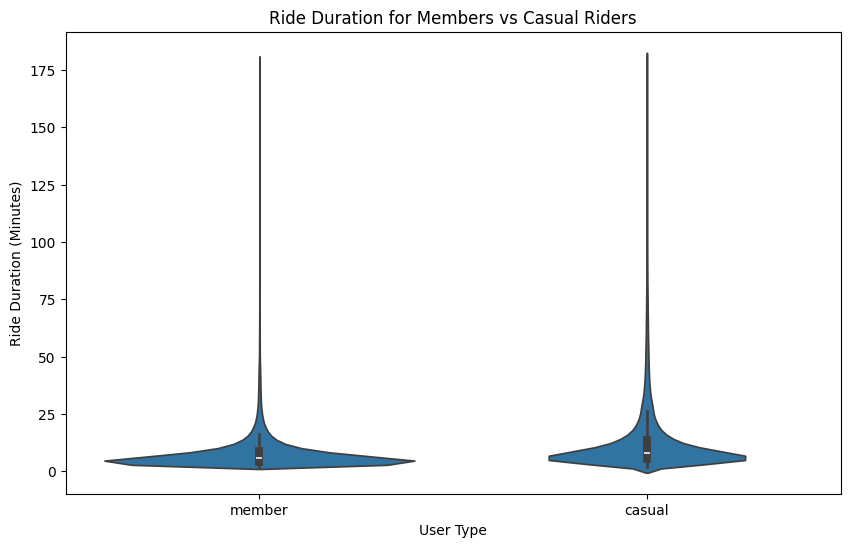

In [23]:
# Violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x='member_casual', y='ride_duration_minutes')
plt.title('Ride Duration for Members vs Casual Riders')
plt.xlabel('User Type')
plt.ylabel('Ride Duration (Minutes)')
plt.show()

### Determining the busiest start stations

<Axes: title={'center': 'Top 10 Busiest Start Stations'}, ylabel='start_station_name'>

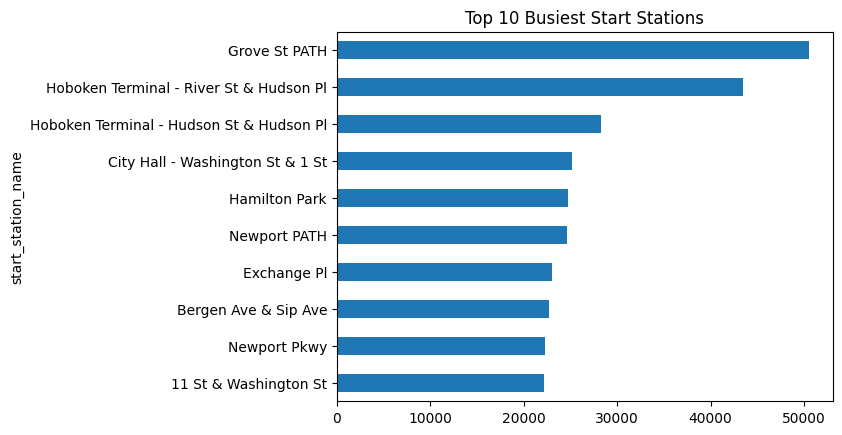

In [24]:
# Counts for top 10 stations
top_10_stations = combined_df['start_station_name'].value_counts().head(10)

# Bar Chart
top_10_stations.sort_values().plot(kind='barh', title='Top 10 Busiest Start Stations')

### Dual axis chart showing the relationship between temperature and ride frequency over an entire year.

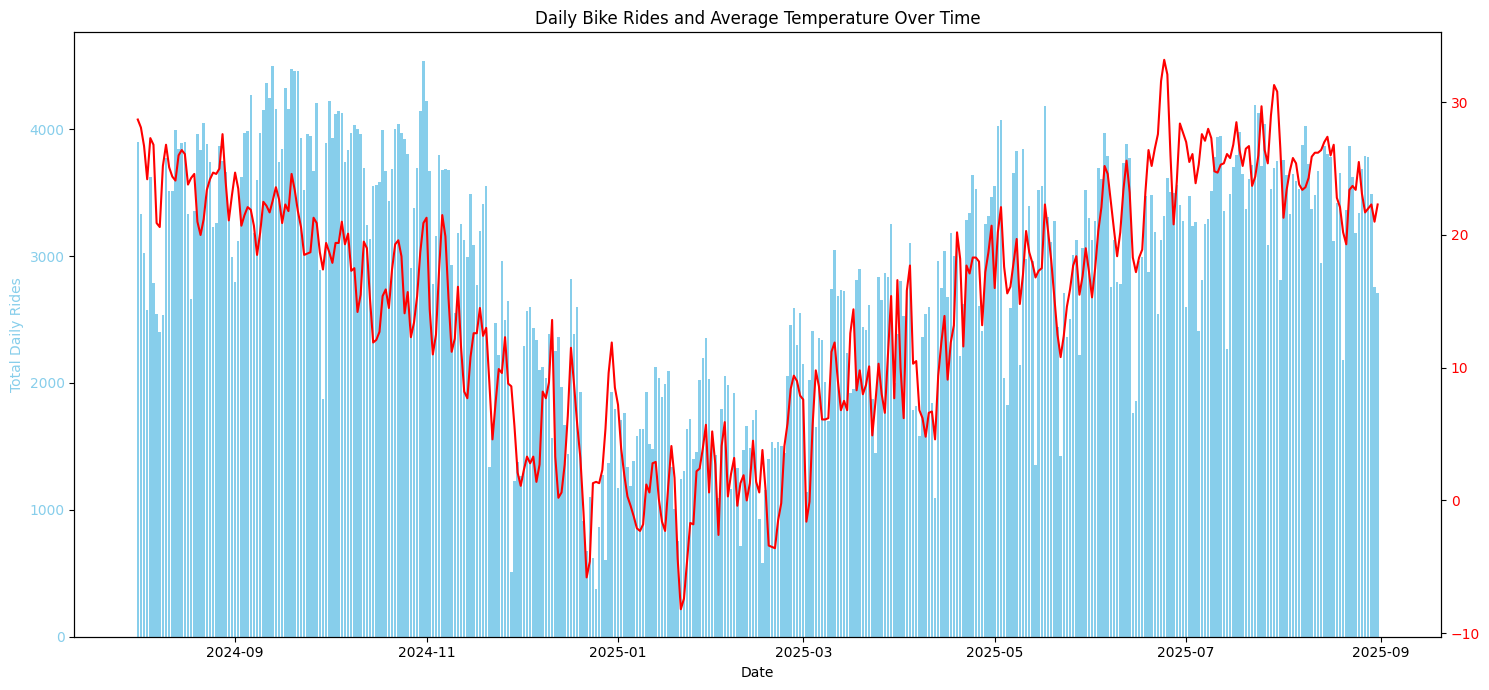

In [25]:
plot_data = merged_df.set_index('date')

fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.bar(plot_data.index, plot_data['ride_count'], color='skyblue', label='Ride Count')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Daily Rides', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()

ax2.plot(plot_data.index, plot_data['tavg'], color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Daily Bike Rides and Average Temperature Over Time')
fig.tight_layout()
plt.show()

# Conclusion

This analysis confirms that NYC bike rental demand is strongly driven by weather, with warmer temperatures significantly increasing ridership. Usage patterns reveal distinct weekday commute peaks and more leisurely weekend activity. Notably, casual riders and annual members exhibit fundamentally different behaviors, particularly in their average trip durations.

### Findings

- **Weather is a primary driver of ridership.** As seen in the time series and scatter plots, daily rides increase consistently with temperature. The correlation heatmap confirms a strong positive correlation between warmer temperatures and ride count, and a negative correlation with precipitation.
- **Usage patterns are dictated by the work week.** The hourly bar charts show two distinct peaks on weekdays (8-9 AM and 5-6 PM), indicating commuter traffic. 
- **Members and casual riders use the service differently.** The violin plot of ride durations clearly shows that casual riders, on average, take notably longer trips than members. 
- **Demand is geographically concentrated.** A small number of stations, particularly those in high-traffic commercial and transit hubs like Grove St and Hoboken River St & Hudson, account for a disproportionate amount of activity, as shown in the "Top 10 Stations" bar chart.

### Actionable Insights

- **Targeted Marketing:** Create marketing campaigns aimed at casual riders promoting "weekend leisure routes" or "sightseeing by bike." For members, promotions could focus on reliability for commuting.
- **Operational Efficiency:** Use the station popularity data to optimize bike redistribution efforts, ensuring the busiest stations are well-stocked before peak commute hours.
- **Demand Management:** To offset low ridership on rainy and/or cold days, the service could pilot a rainy day or seasonal discount program to incentivize hardy riders.